In [1]:
import os
import glob
import mne
import csv
import matplotlib.pyplot as plt
import numpy as np
import scipy
from fooof import FOOOF, FOOOFGroup, fit_fooof_3d
from fooof.sim.gen import gen_aperiodic
import json

/tmp/ipykernel_30163/1207983033.py:8: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF, FOOOFGroup, fit_fooof_3d


In [2]:
egi_c3_chans = ['E30','E36','E41','E31','E37','E42','E54','E53']
egi_c4_chans = ['E105','E104','E103','E80','E87','E93','E79','E86']
brainvision_c3_chans = ["C3", "FC3", "CP3", "C1"]
brainvision_c4_chans = ["C4", "FC4", "CP4", "C2"]

In [3]:
def compute_psds(age):
    subjects = [os.path.split(x)[-1] for x in glob.glob('/home/common/bonaiuto/devmobeta/data/sub-*')]
    subject_age_path = os.path.join('/home/common/bonaiuto/devmobeta/derivatives/')
    subject_age_file = os.path.join(subject_age_path, 'participants_v2.csv')

    sub_psds = []
    freqs = None

    with open(subject_age_file, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            print("Processing row:", row)
            subject = row['subject_id']
            session = row['session']
            system = row['eeg_system']  # Verifying EEG system
            subject_age = row['age']  # Ensure correct formatting (remove spaces, lowercase)
            print("Subject:", subject, "Age:", subject_age)

            if subject_age == age:
                print(f"Processing subject {subject} with age {subject_age} (System: {system})")
                sub_path = os.path.join('/home/common/bonaiuto/devmobeta/derivatives/', subject)
                ses_path = os.path.join(sub_path, session)
                print(ses_path)

                if os.path.exists(os.path.join(ses_path, 'eeg', 'NEARICA_NF')): 
                    print(f"Processing subject {subject} with age {subject_age} and session {session}")
                    eeg_path = os.path.join(ses_path, 'eeg', 'NEARICA_NF')
                    fname = os.path.join(eeg_path, f'03_ica_data/{subject}_task-devmobeta_grasp_eeg_ica_art_rej_interp_reref.set')
                    
                    if os.path.exists(fname):
                        raw_data = mne.io.read_raw_eeglab(fname, preload=True)
                        srate = raw_data.info['sfreq']

                        # Select channels based on EEG system
                        if system == "EGI":
                            c_chans = egi_c3_chans + egi_c4_chans
                        elif system == "BrainVision":
                            c_chans = brainvision_c3_chans + brainvision_c4_chans
                        else:
                            print(f"?? Unknown EEG system for {subject}: {system}")
                            continue

                        c_chan_idx = []
                        for chan in c_chans:
                            if chan in raw_data.info['ch_names']:
                                c_chan_idx.append(raw_data.info['ch_names'].index(chan))
                        c_chan_idx = np.array(c_chan_idx)

                        if len(c_chan_idx) == len(c_chans):
                            data = raw_data.get_data()
                            n_chans = data.shape[0]
                            n_samps = data.shape[1]

                            # Moyenne sur les canaux
                            chan_data = data[c_chan_idx, :]
                            averaged_data = np.mean(chan_data, axis=0)  

                            # Use a window size of 1s with a 50% overlap
                            winsize = srate
                            overlap = int(winsize / 2)    

                            # Calcul du PSD sur les données moyennées
                            freqs, chan_psd = scipy.signal.welch(
                                averaged_data,  # Données moyennées sur les canaux
                                fs=srate, 
                                window='hann', 
                                nperseg=winsize, 
                                noverlap=overlap, 
                                nfft=int(winsize * 20),
                                detrend='constant',
                                return_onesided=True, 
                                scaling='density', 
                                axis=-1, 
                                average='mean'
                            )

                            f_idx = (freqs <= 40)
                            freqs = freqs[f_idx]
                            chan_psd = chan_psd[f_idx]
                            print(f"chan_psd shape: {chan_psd.shape}")

                            sub_psds.append(chan_psd)
                else: 
                    print(f"Processing subject {subject} with age {subject_age} and {session} doesn't exist")
    
    sub_psds = np.array(sub_psds)
    # Définir le chemin du fichier NPZ
    file_path = f"psd_values_{age}.npz"  # Stocké localement dans l'environnement Jupyter
    
    # Sauvegarde des données dans un fichier NPZ
    np.savez(file_path, freqs=freqs, psds=sub_psds)
    
    print(f"PSD sauvegardée dans {file_path}")
    
    return freqs, sub_psds


In [4]:
freqs, sub_three_psds=compute_psds('three')
freqs, sub_six_psds=compute_psds('six')
freqs, sub_twelve_psds=compute_psds('twelve')

Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: three
Processing subject sub-201 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-01
Processing subject sub-201 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: three
Processing subject sub-201 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-201/ses-02
Processing subject sub-201 with age three and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'E

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing subject sub-206 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-01
Processing subject sub-206 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: three
Processing subject sub-206 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-02
Processing subj

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: six
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: twelve
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: three
Processing subject sub-207 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-02
Processing subject sub-207 with age three and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: six
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: twelve
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing subject sub-208 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-01
Processing subject sub-208 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing subject sub-208 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-02
Processing

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing subject sub-209 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-01
Processing subject sub-209 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing subject sub-210 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-01
Processing subject sub-210 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: three
Processing subject sub-211 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-01
Processing subject sub-211 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: six
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-211 Age: twelve
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-212 Age: three
Processing subject sub-212 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-01
Processing subject sub-212 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: three
Processing subject sub-212 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-02
Processing su

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: three
Processing subject sub-213 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-01
Processing subject sub-213 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: three
Processing subject sub-213 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-02
Processing subject sub-213 with age three and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: six
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: twelve
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EG

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: six
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-215 Age: twelve
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: three
Processing subject sub-216 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-01
Processing subject sub-216 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: six
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-216 Age: twelve
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: three
Processing subject sub-217 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-01
Processing subject sub-217 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: six
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-217 Age: twelve
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: three
Processing subject sub-218 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-01
Processing subject sub-218 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: six
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: twelve
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing subject sub-219 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-01
Processing subject sub-219 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing subject sub-220 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-01
Processing subject sub-220 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing subject sub-221 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-01
Processing subject sub-221 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: three
Processing subject sub-221 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-02
Processing subject sub-221 with age three and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: twelve
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-222 Age: three
Processing subject sub-222 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-222/ses-01
Processing subject sub-222 with age three and session ses-01
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: six
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: twelve
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: three
Processing subject sub-224 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-02
Processing subject sub-224 with age three and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: six
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-224 Age: twelve
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: three
Processing subject sub-225 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-01
Processing subject sub-225 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: three
Processing subject sub-225 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-02
Processing subj

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: six
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: twelve
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: three
Processing subject sub-226 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-01
Processing subject sub-226 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: three
Processing subject sub-226 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-02
Processing su

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: six
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: six
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: twelve
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: three
Processing subject sub-227 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-01
Processing subject sub-227 with age three and session ses-01
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'E

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: six
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: twelve
Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-230 Age: three
Processing subject sub-230 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-230/ses-01
Processing subject sub-230 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-230', 'orig_participant_id': 'IM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-230 Age: six
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-231 Age: three
Processing subject sub-231 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-01
Processing subject sub-231 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: six
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: twelve
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: three
Processing subject sub-232 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-232/ses-01
Processing subject sub-232 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: six
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-232 Age: twelve
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: three
Processing subject sub-233 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-01
Processing subject sub-233 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-233 Age: six
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: six
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: three
Processing subject sub-234 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-01
Processing subject sub-234 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-234 Age: three
Processing subject sub-234 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-02
Processing subject su

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: six
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: twelve
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-235 Age: three
Processing subject sub-235 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-235/ses-01
Processing subject sub-235 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-235 Age: six
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-235 Age: twelve
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-236 Age: three
Processing subject sub-236 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-236/ses-01
Processing subject sub-236 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-236 Age: six
Processing row: {'subject_id': 'sub-236', 'orig_participant_id': 'ES', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-236 Age: twelve
Processing row: {'subject_id': 'sub-237', 'orig_participant_id': 'LMP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-237 Age: three
Processing subject sub-237 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-237/ses-01
Processing subject sub-237 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-238 Age: three
Processing subject sub-238 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-01
Processing subject sub-238 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-238 Age: three
Processing subject sub-238 with age three (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-238/ses-02
Processing subject sub-238 with age three and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-238 Age: six
Processing row: {'subject_id': 'sub-238', 'orig_participant_id': 'LM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-238 Age: twelve
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
S

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: twelve
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-242 Age: three
Processing subject sub-242 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-242/ses-01
Processing subject sub-242 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-242', 'orig_participant_id': 'LM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subj

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-250 Age: six
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-250 Age: twelve
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: three
Processing subject sub-251 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-251/ses-01
Processing subject sub-251 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: six
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_sys

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-252 Age: twelve
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: three
Processing subject sub-253 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-253/ses-01
Processing subject sub-253 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: six
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: twelve
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: three
Processing subject sub-254 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-01
Processing subject sub-254 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: six
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: twelve
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: three
Processing subject sub-255 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-01
Processing subject sub-255 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: six
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-255 Age: twelve
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-256 Age: three
Processing subject sub-256 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-256/ses-01
Processing subject sub-256 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-257 Age: three
Processing subject sub-257 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-257/ses-01
Processing subject sub-257 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: three
Processing subject sub-258 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-258/ses-01
Processing subject sub-258 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: six
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-258 Age: twelve
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-259 Age: six
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-259 Age: twelve
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: three
Processing subject sub-260 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-260/se

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-02', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-261 Age: twelve
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: three
Processing subject sub-262 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-01
Processing subject sub-262 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: six
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-262 Age: twelve
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-263 Age: three
Processing subject sub-263 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-263/ses-01
Processing subject sub-263 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-264 Age: three
Processing subject sub-264 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-2

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: six
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: three
Processing subject sub-266 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-266/ses-01
Processing subject sub-266 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: six
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-267 Age: three
Processing subject sub-267 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-267/ses-01
Processing subject sub-267 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-267 Age: six
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-268 Age: three
Processing subject sub-268 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-268/ses-01
Processing subject sub-268 with age three and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-268 Age: six
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-269 Age: three
Processing subject sub-269 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-269 Age: six
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-270 Age: three
Processing subject sub-270 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-270/ses-01
Processing subject sub-270 with age three and session ses-01
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-270 Age: six
Processing row: {'subject_id': 'sub-271', 'orig_participant_id': 'SPP', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-271 Age: six
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M',

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-274 Age: six
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: six
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: twelve
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-276 Age: three
Processing subject sub-276 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-276/ses-01
Processing subject sub-276 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-276 Age: six
Processing row: {'subject_id': 'sub-277', 'orig_participant_id': 'JA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-277 Age: three
Processing subject sub-277 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-277/ses-01
Processing subject sub-277 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-278 Age: three
Processing subject sub-278 with age three (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-278/ses-01
Processing subject sub-278 with age three and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-278 Age: six
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-279 Age: three
Processing subject sub-279 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-279/ses-01
Processing subject sub-279 with age three and session ses-01
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-279 Age: six
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-280 Age: three
Processing subject sub-280 with age three (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-280/ses-01
Processing su

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-06', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: twelve
Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-202 Age: six
Processing subject sub-202 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-202/ses-02
Processing subject sub-202 with age six and session ses-02
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: three
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing subject sub-204 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-01
Processing subject sub-204 with age six and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: three
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing subject sub-205 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-02
Processing subject sub-205 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-206 Age: six
Processing subject sub-206 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-206/ses-04
Processing subject sub-206 with age six and session ses-04


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: twelve
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: three
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: six
Processing subject sub-207 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-207/ses-04
Processing subject sub-207 with age six and session ses-04


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-207', 'orig_participant_id': 'FM', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-207 Age: twelve
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing subject sub-208 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-03
Processing subject sub-208 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing subject sub-209 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-03
Processing subject sub-209 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing subject sub-210 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-03
Processing subject sub-210 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: three
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-211 Age: six
Processing subject sub-211 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-211/ses-03
Processing subject sub-211 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-211', 'orig_participant_id': 'CMB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-211 Age: twelve
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-212 Age: three
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: three
Processing row: {'subject_id': 'sub-212', 'orig_participant_id': 'IV', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-212 Age: six
Processing subject sub-212 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-212/ses-03
Processing subject sub-212 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: three
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: three
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: six
Processing subject sub-213 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-03
Processing subject sub-213 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-213 Age: six
Processing subject sub-213 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-213/ses-04
Processing subject sub-213 

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-213', 'orig_participant_id': 'PG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-213 Age: twelve
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-214 Age: three
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-214 Age: three
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-214 Age: six
Processing subject sub-214 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-214/ses-03
Processing subject sub-214 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-214', 'orig_participant_id': 'AD', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-214 Age: twelve
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: three
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-215 Age: six
Processing subject sub-215 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-215/ses-03
Processing subject sub-215 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-215', 'orig_participant_id': 'BG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-215 Age: twelve
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: three
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-216 Age: six
Processing subject sub-216 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-216/ses-03
Processing subject sub-216 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-216', 'orig_participant_id': 'CG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-216 Age: twelve
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: three
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-217 Age: six
Processing subject sub-217 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-217/ses-03
Processing subject sub-217 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-217', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-217 Age: twelve
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: three
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'ABL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: six
Processing subject sub-218 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-218/ses-02
Processing subject sub-218 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-218', 'orig_participant_id': 'AB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-218 Age: twelve
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing subject sub-219 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-219/ses-02
Processing subject sub-219 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing subject sub-220 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-220/ses-03
Processing subject sub-220 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-221 Age: six
Processing subject sub-221 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-03
Processing subject sub-221 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: six
Processing subject sub-221 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-221/ses-04
Processing subject sub-221 with age six and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: twelve
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-222 Age: three
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-222 Age: three
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-222', 'orig_participant_id': 'SM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-222 Age: twelve
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: three
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: three
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-223 Age: six
Processing subject sub-223 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-223/ses-04
Processing subject sub-223 with age six and session ses-04


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-223', 'orig_participant_id': 'LB', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-223 Age: twelve
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: three
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-224 Age: six
Processing subject sub-224 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-224/ses-03
Processing subject sub-224 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-224', 'orig_participant_id': 'OM', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-224 Age: twelve
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: three
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: three
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-225 Age: six
Processing subject sub-225 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-225/ses-03
Processing subject sub-225 with age six and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-225', 'orig_participant_id': 'MD', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-225 Age: twelve
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: three
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-226 Age: three
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: six
Processing subject sub-226 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-226/ses-03
Processing subject sub-226 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': '

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-226', 'orig_participant_id': 'DLC', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-226 Age: twelve
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: three
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-227 Age: six
Processing subject sub-227 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-227/ses-02
Processing subject sub-227 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-227', 'orig_participant_id': 'HC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-227 Age: twelve
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-228 Age: three
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-228 Age: three
Processing row: {'subject_id': 'sub-228', 'orig_participant_id': 'AFW', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-228 Age: twelve
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-229 Age: three
Processing row: {'subject_id': 'sub-229', 'orig_participant_id': 'AE', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EG

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-231 Age: three
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: six
Processing subject sub-231 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-231/ses-02
Processing subject sub-231 with age six and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-231', 'orig_participant_id': 'JC', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-231 Age: twelve
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-232 Age: three
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'E

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-232', 'orig_participant_id': 'TG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-232 Age: twelve
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: three
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-233 Age: six
Processing subject sub-233 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-03
Processing subject sub-233 with age six and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-233', 'orig_participant_id': 'TB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-233 Age: six
Processing subject sub-233 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-233/ses-04
Processing subject sub-23

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: three
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-234 Age: three
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: six
Processing subject sub-234 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-234/ses-04
Processing subject sub-234 with age six and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-234', 'orig_participant_id': 'MR', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-234 Age: twelve
Processing row: {'subject_id': 'sub-235', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EG

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: six
Processing subject sub-240 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-240/ses-01
Processing subject sub-240 with age six and ses-01 doesn't exist
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-240 Age: six
Processing subject sub-240 with age six (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-240/ses-02
Processing subject sub-240 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: twelve
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-241 Age: three
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing subject sub-241 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-02
Processing subject sub-241 with age six and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-241', 'orig_participant_id': 'IB', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-241 Age: six
Processing subject sub-241 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-241/ses-04
Processing subject sub-241 wit

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-250 Age: twelve
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: three
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: six
Processing subject sub-251 with age six (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-251/ses-02
Processing subject sub-251 with age six and ses-02 doesn't exist
Processing row: {'subject_id': 'sub-251', 'orig_participant_id': 'AP', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-251 Age: twelve
Processing row: {'subject_id': 'sub-252', 'orig_participant_id': 'TE', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'Bra

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: twelve
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: three
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: six
Processing subject sub-254 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-02
Processing subject sub-254 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: twelve
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: three
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: six
Processing subject sub-255 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-02
Processing subject sub-255 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-255 Age: twelve
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-256 Age: three
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-257 Age: three
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: three
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-258 Age: six
Processing subject sub-258 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivative

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-258', 'orig_participant_id': 'AG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-258 Age: twelve
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-259 Age: six
Processing subject sub-259 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-259/ses-01
Processing subject sub-259 with age six and session ses-01
chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-259', 'orig_participant_id': 'MR', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-259 Age: twelve
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-260 Age: three
Processing row: {'subject_id': 'sub-260', 'orig_participant_id': 'OD', 'session': 'ses-0

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-261 Age: three
Processing row: {'subject_id': 'sub-261', 'orig_participant_id': 'ML', 'session': 'ses-02', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-261 Age: twelve
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: three
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: six
Processing subject sub-262 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-02
Processing subject sub-262 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-262 Age: twelve
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-263 Age: three
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-264 Age: three
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-264 Age: twelve
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: three
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', '

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: three
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: six
Processing subject sub-266 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-266/ses-02
Processing subject sub-266 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-267 Age: three
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-267 Age: six
Processing subject sub-267 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-267/ses-02
Processing subject sub-267 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-268 Age: three
Processing row: {'subject_id': 'sub-268', 'orig_participant_id': 'LA', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-268 Age: six
Processing subject sub-268 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-268/ses-02
Processing subject sub-268 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-269 Age: three
Processing row: {'subject_id': 'sub-269', 'orig_participant_id': 'OHM', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-269 Age: six
Processing subject sub-269 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-269/ses-02
Processing subject sub-269 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-270 Age: three
Processing row: {'subject_id': 'sub-270', 'orig_participant_id': 'LP', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-270 Age: six
Processing subject sub-270 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-270/ses-02
Processing subject sub-270 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-271', 'orig_participant_id': 'SPP', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-271 Age: six
Processing subject sub-271 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-271/ses-01
Processing subject sub-271 with age six and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-272 Age: six
Processing subject sub-272 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-272/ses-01
Processing subject sub-272 with age six and session ses-01
Processing row: {'subject_id': 'sub-272', 'orig_participant_id': 'SB', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-272 Age: twelve
Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-273 Age: six
Processing subject sub-273 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-273/ses-01
Processing subject sub-273 with age six and session ses-01


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-273', 'orig_participant_id': 'NL', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-273 Age: twelve
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-274 Age: three
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-274 Age: six
Processing subject sub-274 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-274/ses-02
Processing subject sub-274 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: six
Processing subject sub-275 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-275/ses-01
Processing subject sub-275 with age six and session ses-01
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: twelve
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-276 Age: three
Processing row: {'subject_id': 'sub-276', 'orig_participant_id': 'EG', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-276 Age: six
Processing subject sub-276 with age six (System: BrainVision)
/home/common/bonaiuto/devmobe

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-277', 'orig_participant_id': 'JA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-277 Age: three
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-278 Age: three
Processing row: {'subject_id': 'sub-278', 'orig_participant_id': 'EC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-278 Age: six
Processing subject sub-278 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-278/ses-02
Processing subject sub-278 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-279 Age: three
Processing row: {'subject_id': 'sub-279', 'orig_participant_id': 'LS', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-279 Age: six
Processing subject sub-279 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-279/ses-02
Processing subject sub-279 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-280 Age: three
Processing row: {'subject_id': 'sub-280', 'orig_participant_id': 'ADR', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-280 Age: six
Processing subject sub-280 with age six (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-280/ses-02
Processing subject sub-280 with age six and session ses-02


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
PSD sauvegardée dans psd_values_six.npz
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: three
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: three
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-04', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-201 Age: six
Processing row: {'subject_id': 'sub-201', 'orig_participant_id': 'LZ', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-201 Age: twelve
Processing subject sub-201 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-201/s

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-202', 'orig_participant_id': 'RA', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-202 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: three
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-04', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: six
Processing row: {'subject_id': 'sub-203', 'orig_participant_id': 'NP', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-203 Age: twelve
Processing subject sub-203 with age twelve (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-203/ses-05
Processing subject sub-203 with age twelve and session ses-05


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: six
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-204 Age: twelve
Processing subject sub-204 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-03
Processing subject sub-204 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-204', 'orig_participant_id': 'AJG', 'session': 'ses-04', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-204 Age: twelve
Processing subject sub-204 with age twelve (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-204/ses-04
Processing subject sub-204 with age twelve and session ses-04


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: three
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-205 Age: six
Processing row: {'subject_id': 'sub-205', 'orig_participant_id': 'AL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-205 Age: twelve
Processing subject sub-205 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-205/ses-03
Processing subject sub-205 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-206 Age: three
Processing row: {'subject_id': 'sub-206', 'orig_participant_id': 'MF', 'session': 'ses-02', 'age': 'three', 'sex': 'M', 'eeg_sys

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: three
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: six
Processing row: {'subject_id': 'sub-208', 'orig_participant_id': 'MPG', 'session': 'ses-05', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-208 Age: twelve
Processing subject sub-208 with age twelve (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-208/ses-05
Processing subject sub-208 with age twelve and session ses-05


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: three
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: six
Processing row: {'subject_id': 'sub-209', 'orig_participant_id': 'TA', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-209 Age: twelve
Processing subject sub-209 with age twelve (System: EGI)
/home/common/bonaiuto/devmobeta/derivatives/sub-209/ses-05
Processing subject sub-209 with age twelve and session ses-05


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: three
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-03', 'age': 'six', 'sex': 'M', 'eeg_system': 'EGI'}
Subject: sub-210 Age: six
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-04', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing subject sub-210 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-04
Processing subject sub-210 with age twelve and ses-04 doesn't exist
Processing row: {'subject_id': 'sub-210', 'orig_participant_id': 'SLO', 'session': 'ses-05', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-210 Age: twelve
Processing subject sub-210 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-210/ses-05
Processin

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: three
Processing row: {'subject_id': 'sub-219', 'orig_participant_id': 'EBL', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-219 Age: six
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: three
Processing row: {'subject_id': 'sub-220', 'orig_participant_id': 'SM', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-220 Age: six
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-221 Age: three
Processing row: {'subject_id': 'sub-221', 'orig_participant_id': 'MA', 'session': 'ses-02', 'age': 'three', 'sex': 'F', 'eeg_system': 'EGI'}


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'EGI'}
Subject: sub-239 Age: six
Processing row: {'subject_id': 'sub-239', 'orig_participant_id': 'ABV', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-239 Age: twelve
Processing subject sub-239 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-239/ses-03
Processing subject sub-239 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-240 Age: six
Processing row: {'subject_id': 'sub-240', 'orig_participant_id': 'ABV', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'E

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-243', 'orig_participant_id': 'CD', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-243 Age: three
Processing row: {'subject_id': 'sub-243', 'orig_participant_id': 'CD', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-243 Age: six
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-244 Age: three
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-244 Age: six
Processing row: {'subject_id': 'sub-244', 'orig_participant_id': 'GB', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-244 Age: twelve
Processing subject sub-244 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-244/ses-03
Processing subject sub-244 with age twel

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-246 Age: three
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-246 Age: six
Processing row: {'subject_id': 'sub-246', 'orig_participant_id': 'LMD', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-246 Age: twelve
Processing subject sub-246 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-246/ses-03
Processing subject sub-246 with age twelve and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': ''}
Subject: sub-247 Age: three
Processing row: {'subject_id': 'sub-247', 'orig_participant_id': 'AR', 'session': 'ses-03', 'age': 'six', 'sex': 'F', 'eeg_system': ''}
Subject: sub-247 Age: six
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-248 Age: three
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-248 Age: six
Processing row: {'subject_id': 'sub-248', 'orig_participant_id': 'ZK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-248 Age: twelve
Processing subject sub-248 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-248/ses-03
Processing subject

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-249 Age: three
Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': ''}
Subject: sub-249 Age: six
Processing row: {'subject_id': 'sub-249', 'orig_participant_id': 'EL', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-249 Age: twelve
Processing subject sub-249 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-249/ses-03
Processing subject sub-249 with age twelve and session ses-03
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-250 Age: three
Processing row: {'subject_id': 'sub-250', 'orig_participant_id': 'PZ', 'session': 'ses-02', 'age': 'six', '

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: three
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: six
Processing row: {'subject_id': 'sub-253', 'orig_participant_id': 'RS', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-253 Age: twelve
Processing subject sub-253 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-253/ses-03
Processing subject sub-253 with age twelve and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: three
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: six
Processing row: {'subject_id': 'sub-254', 'orig_participant_id': 'SF', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-254 Age: twelve
Processing subject sub-254 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-254/ses-03
Processing subject sub-254 with age twelve and session ses-03


/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: three
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-255 Age: six
Processing row: {'subject_id': 'sub-255', 'orig_participant_id': 'LH', 'session': 'ses-03', 'age': 'twelve', 'sex': 'M', 'eeg_system': ''}
Subject: sub-255 Age: twelve
Processing subject sub-255 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-255/ses-03
Processing subject sub-255 with age twelve and ses-03 doesn't exist
Processing row: {'subject_id': 'sub-256', 'orig_participant_id': 'AS', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-256 Age: three
Processing row: {'subject_id': 'sub-257', 'orig_participant_id': 'CGM', 'session': 'ses-01', 'age': '

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-01', 'age': 'three', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: three
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-02', 'age': 'six', 'sex': 'F', 'eeg_system': 'BrainVision'}
Subject: sub-262 Age: six
Processing row: {'subject_id': 'sub-262', 'orig_participant_id': 'AK', 'session': 'ses-03', 'age': 'twelve', 'sex': 'F', 'eeg_system': ''}
Subject: sub-262 Age: twelve
Processing subject sub-262 with age twelve (System: )
/home/common/bonaiuto/devmobeta/derivatives/sub-262/ses-03
Processing subject sub-262 with age twelve and session ses-03
Processing row: {'subject_id': 'sub-263', 'orig_participant_id': 'EOG', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': ''}
Subject: sub-263 Age: three
Processing row: {'subject_id': 'sub-264', 'orig_participant_id': 'AH', 'session': 'ses-01', 'age': 'three', 'sex': 'M

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: three
Processing row: {'subject_id': 'sub-265', 'orig_participant_id': 'EB ', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-265 Age: six
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: three
Processing row: {'subject_id': 'sub-266', 'orig_participant_id': 'LC', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-266 Age: six
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-267 Age: three
Processing row: {'subject_id': 'sub-267', 'orig_participant_id': 'FC', 'session': 'ses-02', 'age':

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-01', 'age': 'three', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-274 Age: three
Processing row: {'subject_id': 'sub-274', 'orig_participant_id': 'VT', 'session': 'ses-02', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-274 Age: six
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-01', 'age': 'six', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: six
Processing row: {'subject_id': 'sub-275', 'orig_participant_id': 'LJCT', 'session': 'ses-02', 'age': 'twelve', 'sex': 'M', 'eeg_system': 'BrainVision'}
Subject: sub-275 Age: twelve
Processing subject sub-275 with age twelve (System: BrainVision)
/home/common/bonaiuto/devmobeta/derivatives/sub-275/ses-02
Processing subject sub-275 with age twelve and session ses-02
chan_psd shape: (801,)
Processing row: {'subject_id': 'sub-276', 'orig_participant_id

/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)
/tmp/ipykernel_30163/1206619090.py:31: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_data = mne.io.read_raw_eeglab(fname, preload=True)


In [5]:
print(f'N 3m: {sub_three_psds.shape[0]}')
print(f'N 6m: {sub_six_psds.shape[0]}')
print(f'N 12m: {sub_twelve_psds.shape[0]}')

N 3m: 53
N 6m: 52
N 12m: 19


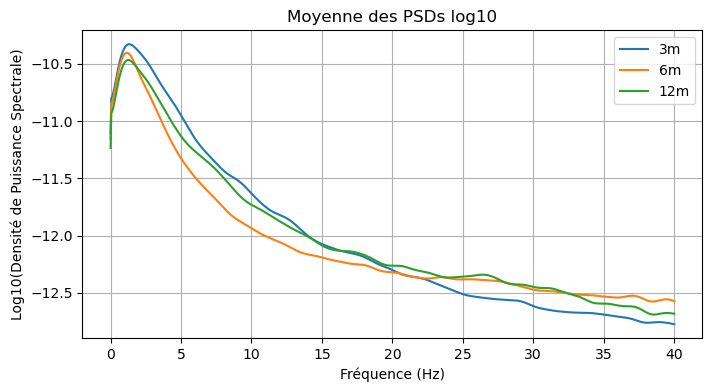

In [6]:
plt.figure(figsize=(8, 4))

# Moyenne sur les sujets pour chaque groupe (en utilisant np.mean sur l'axe des sujets)
# On applique np.log10 pour obtenir le logarithme de la PSD
plt.plot(freqs, np.log10(np.mean(sub_three_psds, axis=0)), label='3m')
plt.plot(freqs, np.log10(np.mean(sub_six_psds, axis=0)), label='6m')
plt.plot(freqs, np.log10(np.mean(sub_twelve_psds, axis=0)), label='12m')

plt.legend()
plt.title('Moyenne des PSDs log10')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Log10(Densité de Puissance Spectrale)')

plt.grid(True)
plt.show()

In [7]:
def parameterize_psds(freqs, sub_psds):
    # check the data shape : (n_subjects, n_freqs)
    n_subjects, n_freqs = sub_psds.shape
    
    # Supposer qu'il n'y a qu'un seul canal (car les données sont déjà moyennées sur les canaux)
    n_chans = 1  # Nombre de canaux fictifs
    sub_psds = sub_psds[:, np.newaxis, :]  # Ajouter une dimension pour les canaux (n_subjects, 1, n_freqs)
    
    fg = FOOOFGroup()  # Créer un groupe FOOOF
    fgs = fit_fooof_3d(fg, freqs, sub_psds, [0.05, 40])  # Appliquer la fonction de fit 3D de fooof

 # Initialization of matrices for periodic and aperiodic components
    sub_periodic = np.zeros_like(sub_psds)
    sub_aperiodic = np.zeros_like(sub_psds)

    for s_idx, fg in enumerate(fgs):
        for chan in range(n_chans):
            if chan in fg.null_inds_:
                sub_aperiodic[s_idx, chan, :] = float('NaN')
                sub_periodic[s_idx, chan, :] = float('NaN')
            else:
                fm = fg.get_fooof(ind=chan, regenerate=True)
                ap_params = fm.get_params('aperiodic_params')
                sub_aperiodic[s_idx, chan, :] = gen_aperiodic(freqs, ap_params)
                sub_periodic[s_idx, chan, :] = np.log10(sub_psds[s_idx, chan, :]) - sub_aperiodic[s_idx, chan, :]
    
    return fgs, sub_periodic, sub_aperiodic


In [8]:
fgs_3m, sub_three_periodic, sub_three_aperiodic=parameterize_psds(freqs, sub_three_psds)
fgs_6m, sub_six_periodic, sub_six_aperiodic=parameterize_psds(freqs, sub_six_psds)
fgs_12m, sub_twelve_periodic, sub_twelve_aperiodic=parameterize_psds(freqs, sub_twelve_psds)

Running FOOOFGroup across 53 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 52 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


Running FOOOFGroup across 19 power spectra.


/home/ldurieux/miniconda3/envs/devmobeta/lib/python3.13/site-packages/fooof/core/funcs.py:87: RuntimeWarning: divide by zero encountered in log10
  ys = offset - np.log10(xs**exp)


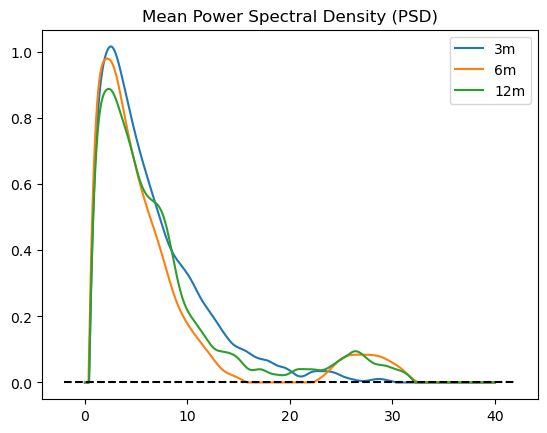

In [9]:
mean_psd_3m=np.mean(np.mean(sub_three_periodic,axis=1),axis=0)
mean_psd_3m[mean_psd_3m<0]=0
mean_psd_6m=np.mean(np.mean(sub_six_periodic,axis=1),axis=0)
mean_psd_6m[mean_psd_6m<0]=0
mean_psd_12m=np.mean(np.mean(sub_twelve_periodic,axis=1),axis=0)
mean_psd_12m[mean_psd_12m<0]=0

plt.plot(freqs,mean_psd_3m,label='3m')
plt.plot(freqs,mean_psd_6m,label='6m')
plt.plot(freqs,mean_psd_12m,label='12m')
plt.plot(plt.xlim(), [0, 0],'k--')
plt.title('Mean Power Spectral Density (PSD)')
plt.legend()

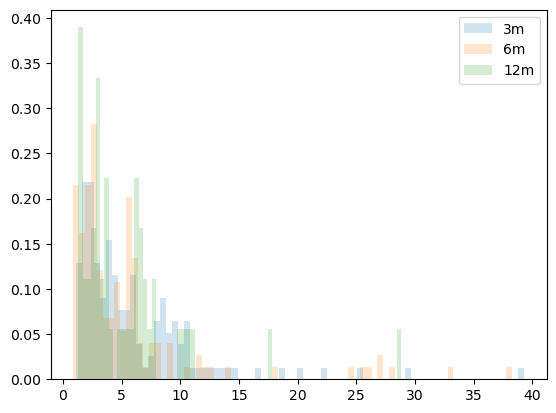

In [10]:
all_peaks_3m = []
all_peaks_6m = []
all_peaks_12m = []

# 3 months
for s_idx, fg in enumerate(fgs_3m):
    fm = fg.get_fooof(ind=0, regenerate=True)  # Only one channel here, so we set ind=0
    peaks = fm.get_params('peak_params', 'CF')
    if isinstance(peaks, np.ndarray):
        all_peaks_3m.extend(peaks)
    else:
        all_peaks_3m.append(peaks)

# 6 months
for s_idx, fg in enumerate(fgs_6m):
    fm = fg.get_fooof(ind=0, regenerate=True)  
    peaks = fm.get_params('peak_params', 'CF')
    if isinstance(peaks, np.ndarray):
        all_peaks_6m.extend(peaks)
    else:
        all_peaks_6m.append(peaks)

# 12 months
for s_idx, fg in enumerate(fgs_12m):
    fm = fg.get_fooof(ind=0, regenerate=True)  
    peaks = fm.get_params('peak_params', 'CF')
    if isinstance(peaks, np.ndarray):
        all_peaks_12m.extend(peaks)
    else:
        all_peaks_12m.append(peaks)

# Affichage des histogrammes
plt.hist(all_peaks_3m, 75, alpha=.2, density=True, label='3m')
plt.hist(all_peaks_6m, 75, alpha=.2, density=True, label='6m')
plt.hist(all_peaks_12m, 75, alpha=.2, density=True, label='12m')
plt.legend()


In [11]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import json

def define_fois(freqs, mean_psd, age, debug=False):
    # Initialisation des variables
    mean_resid = mean_psd
    foi_pk_freqs = []
    foi_pk_vals = []    
    foi_fwhms = []
    foi_ranges = []
    foi_info = {} 
    foi_counter = 1  
    
    # Trouver les pics initiaux
    orig_pks, properties = scipy.signal.find_peaks(mean_resid)
    
    while True:
        pks, properties = scipy.signal.find_peaks(mean_resid)

        pk_vals = mean_resid[pks]
        sorted_idx = np.argsort(-pk_vals)
        pk_vals = pk_vals[sorted_idx]
        pks = pks[sorted_idx]

        pk_idx = pks[0]
        pk_val = pk_vals[0]
        pk_freq = freqs[pk_idx]
        
        # Condition d'arrêt
        if pk_val < np.std(mean_resid):
            if debug:
                print(f'Peak val={pk_val}, thresh={0.5 * np.std(mean_resid)}')
            break
        
        # Recherche des indices de largeur de demi-crête (FWHM)
        l_idx = np.where(mean_resid[:pk_idx] <= pk_val * 0.5)[0]
        r_idx = np.where(mean_resid[pk_idx:] <= pk_val * 0.5)[0]

        if len(l_idx) and len(r_idx):
            l_freq = freqs[l_idx[-1]]
            r_freq = freqs[pk_idx + r_idx[0]]
            r_side = (r_freq - pk_freq)
            l_side = (pk_freq - l_freq)
            fwhm = 2 * np.min([r_side, l_side])
        elif len(l_idx):
            l_freq = freqs[l_idx[-1]]
            fwhm = 2 * (pk_freq - l_freq)
        elif len(r_idx):
            r_freq = freqs[pk_idx + r_idx[0] + 1]
            fwhm = 2 * (r_freq - pk_freq)

        l_freq = pk_freq - fwhm * 0.5
        r_freq = pk_freq + fwhm * 0.5
        sd = fwhm / (2 * np.sqrt(2 * np.log(2)))
        A = pk_vals[0] * np.exp(-0.5 * ((freqs - pk_freq) / sd) ** 2)
        nearest_orig = np.min(np.abs(freqs[np.array(orig_pks)] - pk_freq))
        
        # Conditions pour valider le pic
        if pk_val > np.std(mean_resid) and ((pk_freq < 10 and fwhm > 1.7) or (pk_freq >= 10 and fwhm > 2.3)):
            print(f'Peak: freq={pk_freq}, val={pk_val}, width={fwhm}, range={pk_freq - fwhm * 0.5}-{pk_freq + fwhm * 0.5}')
            print(f'Distance to nearest original peak={nearest_orig}')
            if debug:
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 2, 1)
                plt.plot(freqs, mean_resid)
                plt.plot(freqs[pks], mean_resid[pks], 'ro')
                plt.subplot(1, 2, 2)
                plt.plot(freqs, mean_resid)
                plt.plot(freqs, A)
            
            # Ajouter les résultats à la liste
            foi_pk_freqs.append(pk_freq)
            foi_pk_vals.append(pk_val)
            foi_fwhms.append(fwhm)
            foi_ranges.append([l_freq, r_freq])

            band_name = f'FOI_{foi_counter}'
            foi_info[band_name] = {'frequency_range': [l_freq, r_freq], 'peak_frequency': pk_freq}
            foi_counter += 1
            
        elif debug:
            if not ((pk_freq < 10 and fwhm > 1.7) or (pk_freq >= 10 and fwhm > 2.3)):
                print(f'Peak: freq={pk_freq}, fhwm={fwhm} to narrow')
            if pk_val <= np.std(mean_resid):
                print(f'Peak: freq={pk_freq} too low amplitude')
           
        mean_resid = mean_resid - A  # Mise à jour du signal résiduel

    # Tri des pics
    sorted_idx = np.argsort(foi_pk_freqs)
    
    foi_pk_freqs = np.array(foi_pk_freqs)
    foi_pk_vals = np.array(foi_pk_vals)
    foi_fwhms = np.array(foi_fwhms)
    foi_ranges = np.array(foi_ranges)
    
    foi_pk_freqs = foi_pk_freqs[sorted_idx]
    foi_pk_vals = foi_pk_vals[sorted_idx]
    foi_fwhms = foi_fwhms[sorted_idx]
    foi_ranges = foi_ranges[sorted_idx, :]
    
    # Sauvegarde des informations dans un fichier JSON
    with open(f'frequency_ranges_{age}_merged.json', 'w') as json_file:
        json.dump(foi_info, json_file)
    
    # Plot des résultats
    plt.figure()
    plt.plot(freqs, mean_psd, label='Mean PSD')
    for f_idx in range(foi_ranges.shape[0]):
        sd = foi_fwhms[f_idx] / (2 * np.sqrt(2 * np.log(2)))
        A = foi_pk_vals[f_idx] * np.exp(-0.5 * ((freqs - foi_pk_freqs[f_idx]) / sd) ** 2)
        plt.plot(freqs, A)
        plt.title(f'Peak Detection for {age} months')
        plt.savefig(f'/home/ldurieux/devmobeta_grasp/beta_frequency_{age}.pdf', dpi=300, bbox_inches='tight')
    
    return foi_info, foi_pk_freqs, foi_pk_vals, foi_fwhms, foi_ranges


Peak: freq=2.5500000000000003, val=1.0164993895227166, width=3.5000000000000004, range=0.8-4.300000000000001
Distance to nearest original peak=0.0
Peak: freq=6.050000000000001, val=0.5619077610239899, width=3.9000000000000004, range=4.1000000000000005-8.0
Distance to nearest original peak=3.5000000000000004
Peak: freq=10.0, val=0.2960002092792819, width=4.1, range=7.95-12.05
Distance to nearest original peak=7.449999999999999
Peak: freq=13.5, val=0.11338252823940073, width=3.3999999999999986, range=11.8-15.2
Distance to nearest original peak=9.150000000000002
Peak: freq=17.35, val=0.0669787671340366, width=4.800000000000001, range=14.950000000000001-19.75
Distance to nearest original peak=5.300000000000001


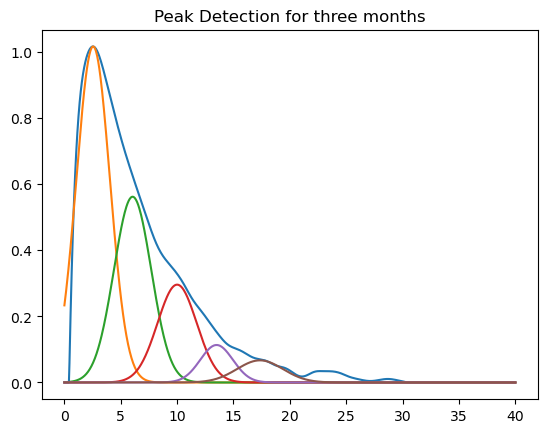

In [12]:
foi_info_3m, foi_pk_freqs_3m,foi_pk_vals_3m,foi_fwhms_3m,foi_ranges_3m=define_fois(freqs, mean_psd_3m, 'three', debug=False)

Peak: freq=2.2, val=0.979808385972391, width=3.0, range=0.7000000000000002-3.7
Distance to nearest original peak=0.0
Peak: freq=5.15, val=0.5611574581829167, width=3.4000000000000004, range=3.45-6.8500000000000005
Distance to nearest original peak=2.95
Peak: freq=8.0, val=0.2562341142819317, width=3.0, range=6.5-9.5
Distance to nearest original peak=5.8
Peak: freq=10.75, val=0.11860895115258101, width=2.8999999999999986, range=9.3-12.2
Distance to nearest original peak=8.55
Peak: freq=26.700000000000003, val=0.08415428527745623, width=5.400000000000006, range=24.0-29.400000000000006
Distance to nearest original peak=0.0


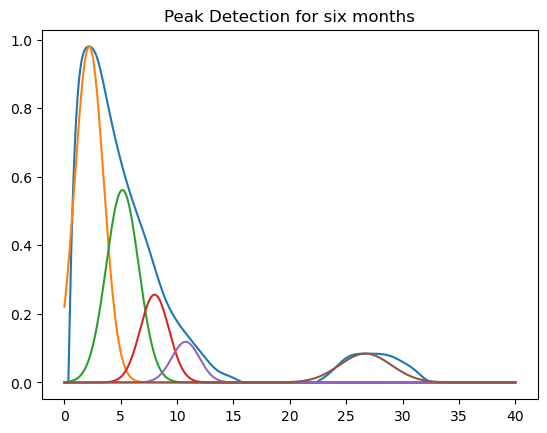

In [13]:
foi_info_6m, foi_pk_freqs_6m,foi_pk_vals_6m,foi_fwhms_6m,foi_ranges_6m=define_fois(freqs, mean_psd_6m, 'six', debug=False)

Peak: freq=2.3000000000000003, val=0.8883425577676254, width=3.1000000000000005, range=0.75-3.8500000000000005
Distance to nearest original peak=0.0
Peak: freq=5.6000000000000005, val=0.5532737001154313, width=3.9000000000000004, range=3.6500000000000004-7.550000000000001
Distance to nearest original peak=3.3000000000000003
Peak: freq=8.25, val=0.27763679702423516, width=2.6999999999999993, range=6.9-9.6
Distance to nearest original peak=5.949999999999999
Peak: freq=10.9, val=0.15340810332338142, width=2.6999999999999993, range=9.55-12.25
Distance to nearest original peak=6.1
Peak: freq=26.400000000000002, val=0.09450608904524718, width=5.0, range=23.900000000000002-28.900000000000002
Distance to nearest original peak=0.0
Peak: freq=14.0, val=0.08590828875093591, width=3.299999999999997, range=12.350000000000001-15.649999999999999
Distance to nearest original peak=3.0
Peak: freq=20.85, val=0.037162716744517425, width=3.6000000000000014, range=19.05-22.650000000000002
Distance to neares

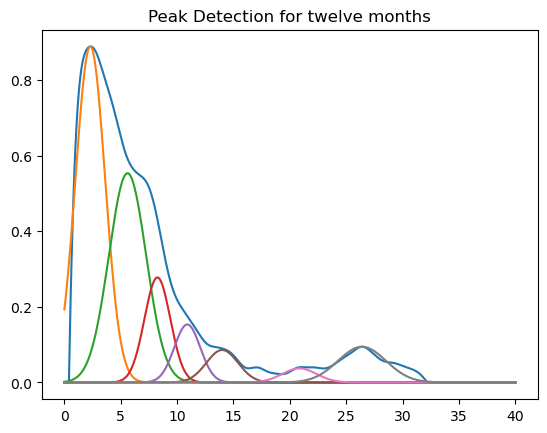

In [14]:
foi_info_12m,foi_pk_freqs_12m,foi_pk_vals_12m,foi_fwhms_12m,foi_ranges_12m=define_fois(freqs, mean_psd_12m, 'twelve', debug=False)

In [15]:
foi_ranges_3m

array([[ 0.8 ,  4.3 ],
       [ 4.1 ,  8.  ],
       [ 7.95, 12.05],
       [11.8 , 15.2 ],
       [14.95, 19.75]])

In [16]:
foi_ranges_6m

array([[ 0.7 ,  3.7 ],
       [ 3.45,  6.85],
       [ 6.5 ,  9.5 ],
       [ 9.3 , 12.2 ],
       [24.  , 29.4 ]])

In [17]:
foi_ranges_12m

array([[ 0.75,  3.85],
       [ 3.65,  7.55],
       [ 6.9 ,  9.6 ],
       [ 9.55, 12.25],
       [12.35, 15.65],
       [19.05, 22.65],
       [23.9 , 28.9 ]])